In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

from inference.loss import LossTeaching
from inference.train import train

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set()

We assume the following model:

\begin{align}
Z_u^\rho &\sim \mathcal{N}(0, \sigma_u^\rho)\\
Z_w^\rho &\sim \mathcal{N}(0, \sigma_w^\rho) \\
Z_{u, w}^\rho &= \mu^\rho + Z_u^\rho + Z_w^\rho \\
\end{align}
where $Z_u^{\rho}$ is a random variable whose distribution is specific to user $u$ and parameter $\rho$, and $\rho \in {\alpha, \beta}$.

The probability of recall for user $u$ and item/word $w$ at time $t$ is defined as:
\begin{align}
p(\omega = 1 \mid t, u, w) &= e^{-Z_{u, w}^\alpha (1-Z_{u, w}^\beta)^n \delta_{u, w}^t}  \\
\end{align}
where $\delta_{u, w}^t$ is the time elapsed since the last presentation for user $u$, item $w$ at time $t$.


# Run on experimental data

In [3]:
df = pd.read_csv("../../data/data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values
# Copy actual item ID
df["item_id"] = df.item
for i, i_id in enumerate(df.item_id.unique()): 
    df.loc[df.item_id == i_id, 'item'] = i
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done,timestamp,item_id
49739,goldfish@active.fi,active.fi,ThresholdCondition,0,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14,1.601488e+09,1506
49740,goldfish@active.fi,active.fi,ThresholdCondition,1,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14,1.601488e+09,190
49741,goldfish@active.fi,active.fi,ThresholdCondition,2,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14,1.601488e+09,1000
49742,goldfish@active.fi,active.fi,ThresholdCondition,0,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14,1.601488e+09,1506
49743,goldfish@active.fi,active.fi,ThresholdCondition,1,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14,1.601488e+09,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,103,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14,1.602136e+09,179
147618,azalea@active.fi,active.fi,ThresholdCondition,1349,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14,1.602136e+09,1071
147619,azalea@active.fi,active.fi,ThresholdCondition,563,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14,1.602136e+09,1196
147620,azalea@active.fi,active.fi,ThresholdCondition,202,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14,1.602136e+09,1282


In [4]:
n_u = len(df.user.unique())
n_o_by_u = np.zeros(shape=n_u, dtype=int)
for u, (user, user_df) in enumerate(df.groupby("user")):
    n_o_by_u[u] = len(user_df) - len(user_df.item.unique()) # Do not count first presentation
n_o_max = n_o_by_u.max()
n_o_min = n_o_by_u.min()
n_obs = n_o_by_u.sum()
print("number of user", n_u)
print("total number of observations (excluding first presentation)", n_obs)
print("minimum number of observation for a single user", n_o_min)
print("maximum number of observation for a single user", n_o_max)

number of user 53
total number of observations (excluding first presentation) 70618
minimum number of observation for a single user 1285
maximum number of observation for a single user 1404


In [5]:
y = np.zeros(shape=n_obs, dtype=int)
x = np.zeros(shape=n_obs, dtype=float)
w = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)

idx = 0

for i_u, (user, user_df) in enumerate(df.groupby("user")):
    
    user_df = user_df.sort_values(by="timestamp")
    seen = user_df.item.unique()
    w_u = user_df.item.values      # Words
    ts_u = user_df.timestamp.values
    counts = {word: -1 for word in seen}
    last_pres = {word: None for word in seen}
    r_u = np.zeros(len(user_df))   # Number of repetitions
    x_u = np.zeros(r_u.shape)      # Time elapsed since last repetition 
    for i, word in enumerate(w_u):
        ts = ts_u[i]
        r_u[i] = counts[word]
        if last_pres[word] is not None:
            x_u[i] =  ts - last_pres[word]
        counts[word] += 1
        last_pres[word] = ts
    
    to_keep = r_u >= 0
    y_u = user_df.success.values[to_keep]
    r_u = r_u[to_keep]
    w_u = w_u[to_keep]
    x_u = x_u[to_keep]
    
    n_ou = len(y_u)
    # assert n_o_by_u[i_u] == n_ou
    
    y[idx:idx+n_ou] = y_u
    x[idx:idx+n_ou] = x_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou

In [6]:
data = {
    'u': u, 'w': w, 
    'x': torch.from_numpy(x.reshape(-1, 1)), 
    'r': torch.from_numpy(r.astype(float).reshape(-1, 1)),
    'y': torch.from_numpy(y.astype(float).reshape(-1, 1))}

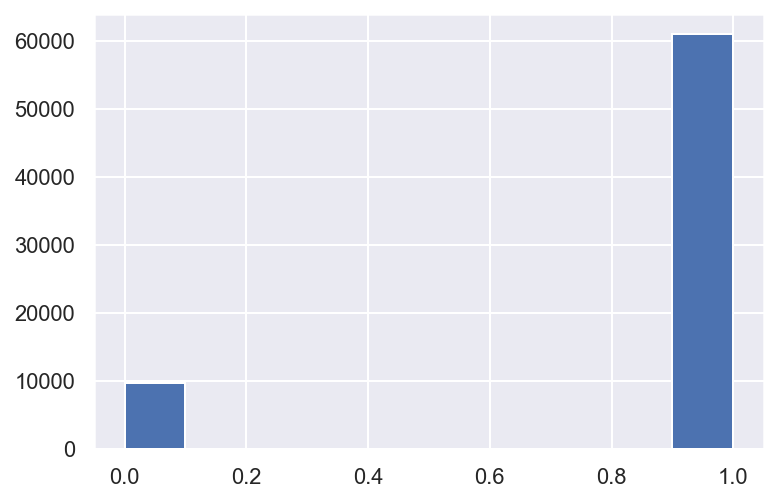

In [7]:
plt.hist(y);

In [ ]:
z_flow, theta_flow, hist_loss = train(
    data,
    n_sample=40,
    epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
plot_loss(hist_loss)

In [ ]:
plot_posterior(theta_flow)